In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
df = pd.read_csv('total-visitor-international-arrivals-monthly.csv')

In [3]:
df.head()

,month,total_international_visitor_arrivals
0,1978-01,167016
1,1978-02,147954
2,1978-03,163199
3,1978-04,162400
4,1978-05,162667


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Data columns (total 2 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   month                                 455 non-null    object
 1   total_international_visitor_arrivals  455 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 7.2+ KB


In [5]:
df['month'] = pd.to_datetime(df['month'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Data columns (total 2 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   month                                 455 non-null    datetime64[ns]
 1   total_international_visitor_arrivals  455 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 7.2 KB


In [7]:
df.head()

,month,total_international_visitor_arrivals
0,1978-01-01,167016
1,1978-02-01,147954
2,1978-03-01,163199
3,1978-04-01,162400
4,1978-05-01,162667


In [8]:
df.rename(columns={'month' : 'date' ,'total_international_visitor_arrivals' : 'visitor_arrivals'}, inplace= True)

In [9]:
df.head()

,date,visitor_arrivals
0,1978-01-01,167016
1,1978-02-01,147954
2,1978-03-01,163199
3,1978-04-01,162400
4,1978-05-01,162667


# EDA

In [10]:
df.describe()

,visitor_arrivals
count,4.550000e+02
mean,5.979358e+05
std,3.231659e+05
min,1.479540e+05
25%,2.954955e+05
50%,5.696220e+05
75%,7.717955e+05
max,1.519188e+06


## Minimum Visitor Arrivals

In [11]:
df[df['visitor_arrivals'] == df['visitor_arrivals'].min()]

,date,visitor_arrivals
1,1978-02-01,147954


## Maximum Visitor Arrivals

In [12]:
df[df['visitor_arrivals'] == df['visitor_arrivals'].max()]

,date,visitor_arrivals
450,2015-07-01,1519188


## Line Chart

In [13]:
line_month = df.groupby('date').sum()
line_month.head()

,visitor_arrivals
date,
1978-01-01,167016
1978-02-01,147954
1978-03-01,163199
1978-04-01,162400
1978-05-01,162667


In [14]:
line_year = df.groupby(pd.Grouper(key = 'date', freq='Y')).mean()
line_year.head()

,visitor_arrivals
date,
1978-12-31,170602.000000
1979-12-31,187257.583333
1980-12-31,213507.083333
1981-12-31,235741.583333
1982-12-31,246390.833333


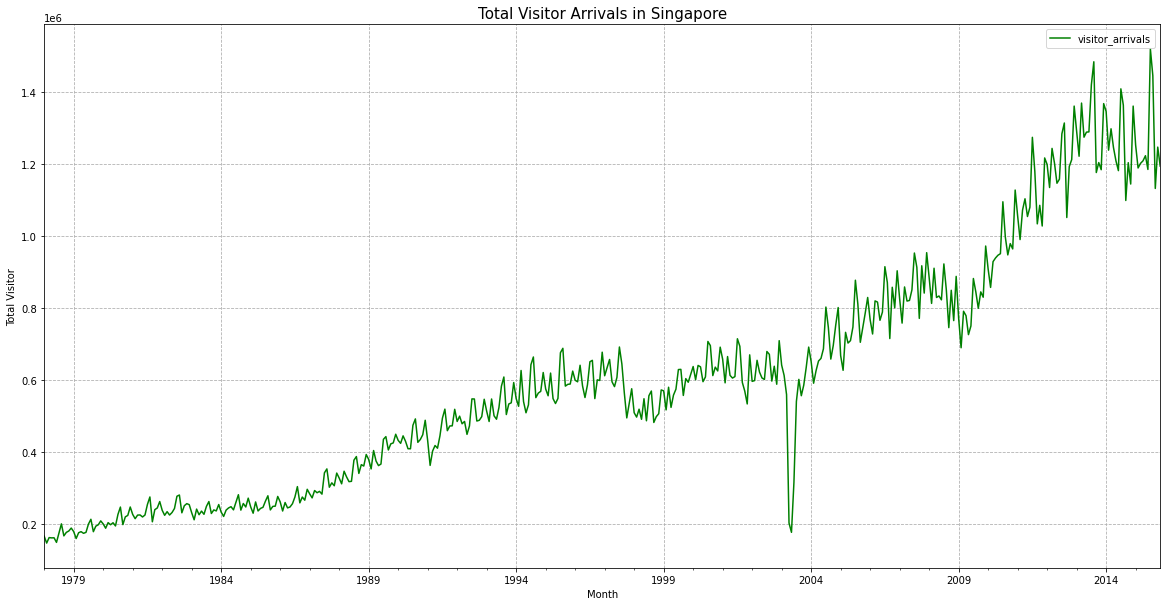

In [15]:
fig, axes = plt.subplots(figsize = (20,10))
line_month.plot(kind = 'line', ax = axes, color = 'green')
plt.title('Total Visitor Arrivals in Singapore', size = 15)
plt.xlabel('Month')
plt.ylabel('Total Visitor')
plt.grid(linestyle = '--')
plt.show()

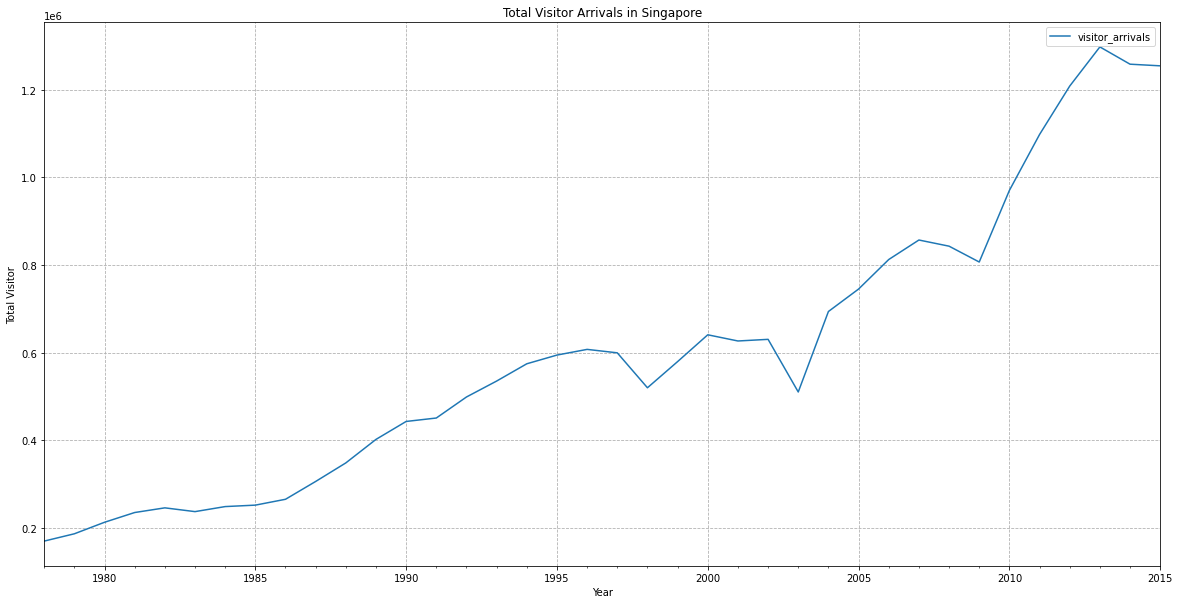

In [16]:
fig, axes = plt.subplots(figsize = (20,10))
line_year.plot(kind = 'line', ax = axes)
plt.title('Total Visitor Arrivals in Singapore')
plt.xlabel('Year')
plt.ylabel('Total Visitor')
plt.grid(linestyle = '--')
plt.show()

## Seasonal Decompose

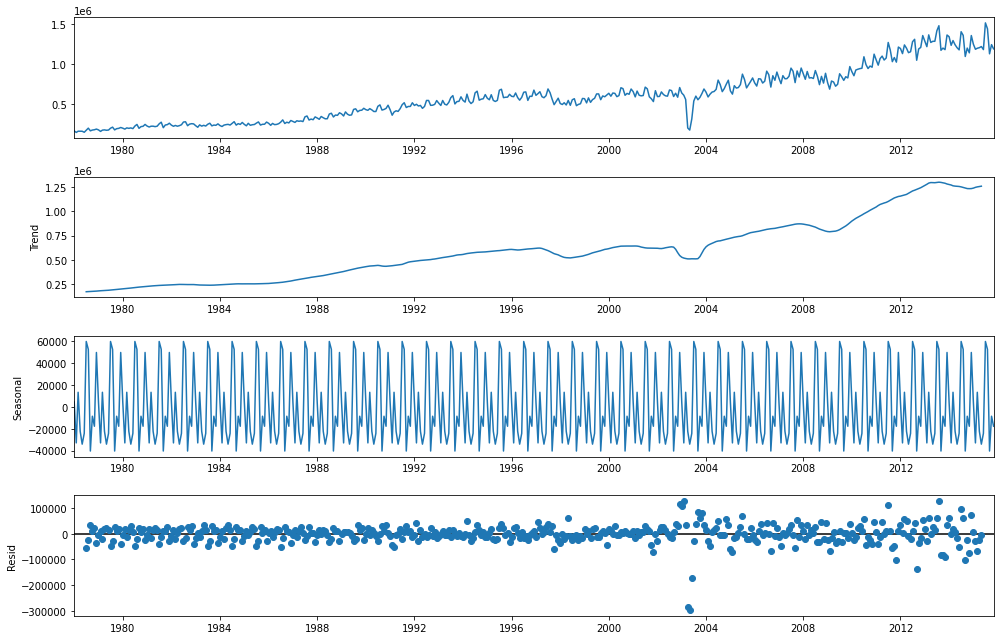

In [17]:
# Start to decompose
import pylab
from statsmodels.tsa.seasonal import seasonal_decompose

pylab.rcParams['figure.figsize'] = (14, 9)

# We try to look at the data in yearly period, since the data are in monthly period, we aggregate it into 12 period
res = seasonal_decompose(line_month,model='additive')
ax=res.plot()
plt.show()

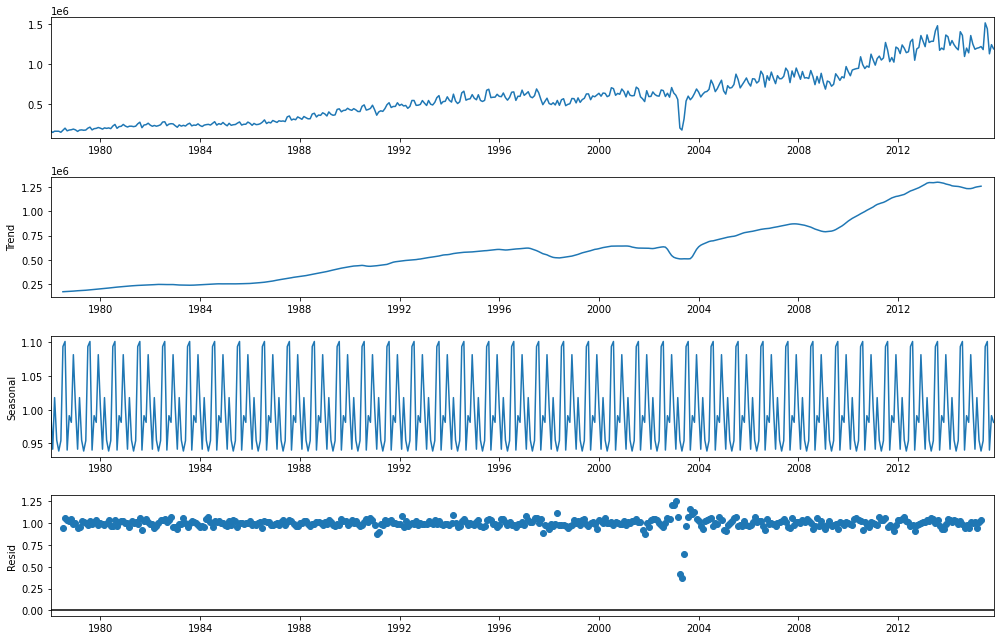

In [18]:
# We try to look at the data in yearly period, since the data are in monthly period, we aggregate it into 12 period
res = seasonal_decompose(line_month,model='multiplicative')
ax=res.plot()
plt.show()

# Modeling

### Split Train-set and Test-set

In [19]:
split_date = '2010-01-01'
df_train = df.loc[df['date'] <= split_date].copy()
df_test = df.loc[df['date'] > split_date].copy()

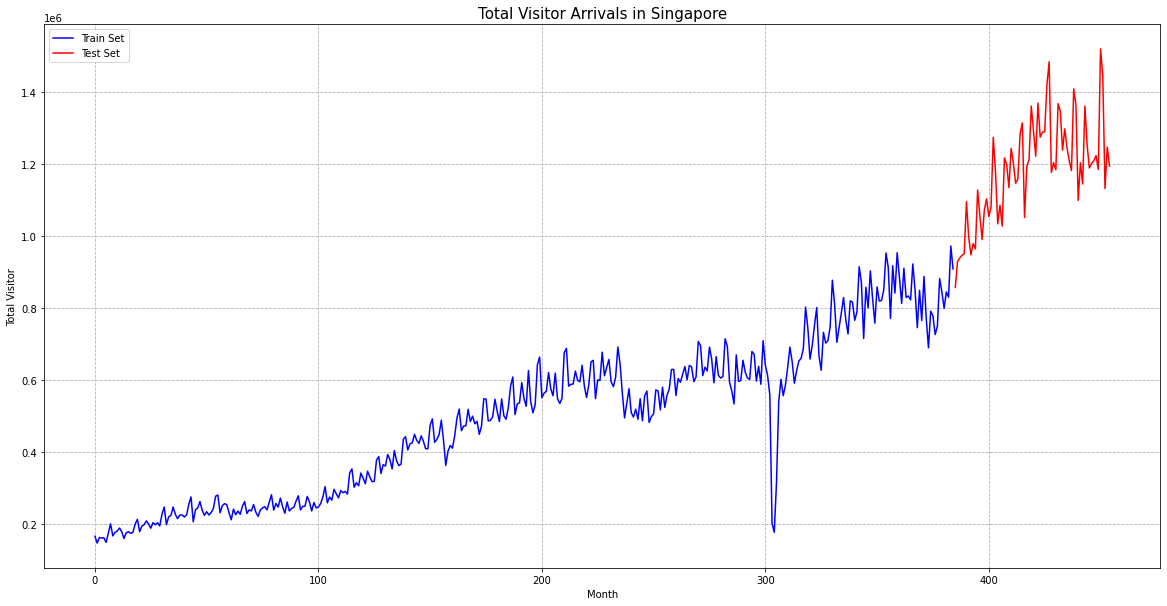

In [20]:
fig, axes = plt.subplots(figsize = (20,10))
df_train['visitor_arrivals'].plot(kind = 'line', ax = axes, color = 'blue', label = 'Train Set')
df_test['visitor_arrivals'].plot(kind = 'line', ax = axes, color = 'red', label = 'Test Set')
plt.title('Total Visitor Arrivals in Singapore', size = 15)
plt.xlabel('Month')
plt.ylabel('Total Visitor')
plt.grid(linestyle = '--')
plt.legend()
plt.show()

### Create Features

In [21]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    
    X = df[['quarter','month','year']]
    
    if label:
        y = df[label]
        return X, y
    return X

In [22]:
X_train, y_train = create_features(df_train, label='visitor_arrivals')
X_test, y_test = create_features(df_test, label='visitor_arrivals')

In [23]:
X_train.head()

,quarter,month,year
0,1,1,1978
1,1,2,1978
2,1,3,1978
3,2,4,1978
4,2,5,1978


In [24]:
X_test.head()

,quarter,month,year
385,1,2,2010
386,1,3,2010
387,2,4,2010
388,2,5,2010
389,2,6,2010


# Model 1

In [32]:
model = xgb.XGBRegressor(n_estimators=1000)
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

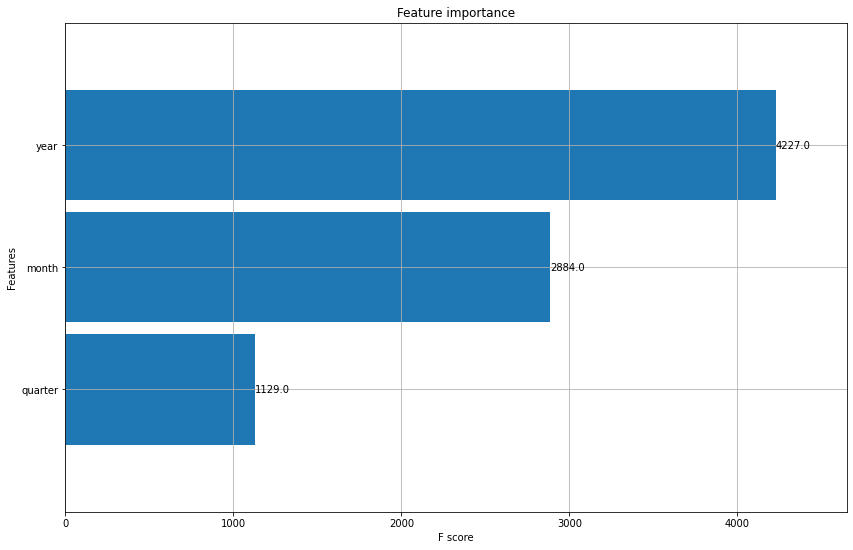

In [33]:
feature_imp = plot_importance(model, height=0.9)

## Forecast on Test-set

In [40]:
df_test['Visitor_Prediction'] = model.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

In [50]:
df_all.head(20)

,date,visitor_arrivals,quarter,month,year,Visitor_Prediction
385,2010-02-01,857387,1,2,2010,841795.3750
386,2010-03-01,928903,1,3,2010,904412.0000
387,2010-04-01,939013,2,4,2010,892995.7500
388,2010-05-01,946676,2,5,2010,863531.0625
389,2010-06-01,951032,2,6,2010,875204.5625
390,2010-07-01,1095047,3,7,2010,945455.5000
391,2010-08-01,996899,3,8,2010,915745.4375
392,2010-09-01,947585,3,9,2010,881620.0000
393,2010-10-01,978913,4,10,2010,909965.3125
394,2010-11-01,964170,4,11,2010,892477.6875


<AxesSubplot:>

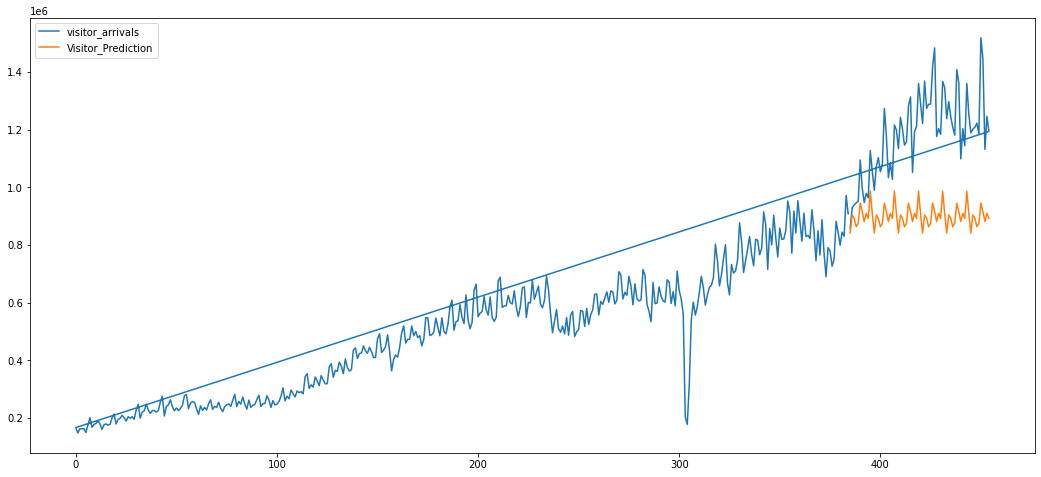

In [47]:
df_all[['visitor_arrivals','Visitor_Prediction']].plot(figsize=(18, 8))

# Model 2